<a href="https://colab.research.google.com/github/seansothey/CSC685/blob/master/Project7_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://dataanalyticsedge.com/wp-content/uploads/2019/11/stocks_BSE_Nifty_Sensex__markets_bse_nse_nifty-1_1280-770x433.jpg)

Predicting how the stock market will perform is one of the most difficult things to do. There are so many factors involved in the prediction – physical factors vs. physhological, rational and irrational behaviour, etc. All these aspects combine to make share prices volatile and very difficult to predict with a high degree of accuracy.

Can we use machine learning as a game changer in this domain? In this project, historical stock prices data of Apple and Amazon company, from 2006 to 2017, were used for experimentation, using machine learning techniques, such as RNN, LSTM, and GRU.


#Setup

In [1]:
# Common Import
import sklearn
import pandas as pd
import numpy as np

# Algorithm libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math

# Visaulization libraries
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'0.22.2.post1'

#Load Data

In [0]:
apple_stock = pd.read_csv('https://raw.githubusercontent.com/seansothey/CSC685/master/AAPL_2006-01-01_to_2018-01-01.csv',index_col='Date', parse_dates=["Date"]) 

In [3]:
apple_stock

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL
...,...,...,...,...,...,...
2017-12-22,174.68,175.42,174.50,175.01,16349444,AAPL
2017-12-26,170.80,171.47,169.68,170.57,33185536,AAPL
2017-12-27,170.10,170.78,169.71,170.60,21498213,AAPL


Check if there're missing data

In [4]:
apple_stock.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

No missing values. GREAT !!!

The assignment promts to use 12 motnths record; therefore, let's use data in 2016 as a training set and 2017 as a test set, by using only price 'High' column

In [0]:
train_2016 = apple_stock['2016':'2016'].iloc[:,1:2].values
test_2017 = apple_stock['2017':].iloc[:,1:2].values

In [6]:
train_2016.shape, test_2017.shape

((252, 1), (251, 1))

###Visualization of "High" attribute

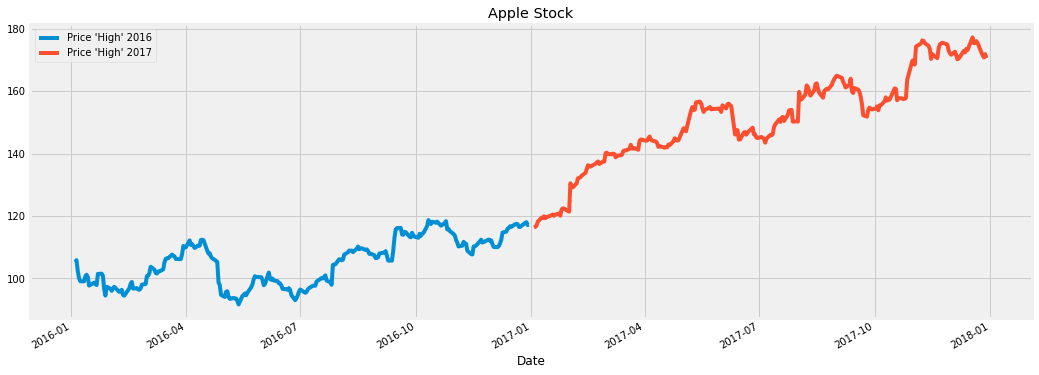

In [7]:
apple_stock["High"]['2016':'2016'].plot(figsize=(16,6), legend=True)
apple_stock["High"]["2017":].plot(figsize=(16,6), legend=True)
plt.legend(["Price 'High' 2016", "Price 'High' 2017"])
plt.title("Apple Stock")
plt.show()

###Scale the training set

In [0]:
sc = MinMaxScaler(feature_range=(0,1))
train_sc = sc.fit_transform(train_2016)

###Create traininig set for LSTM with X=10 days for each output y

In [0]:
X_train = []
y_train = []

for i in range(10,252):
    X_train.append(train_sc[i-10:i, 0])
    y_train.append(train_sc[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
X_train[0] # 10 days data

array([0.50703183, 0.52479645, 0.39600296, 0.31310141, 0.27535159,
       0.27350111, 0.33382679, 0.35233161, 0.32605477, 0.22353812])

In [11]:
y_train[0]

0.2583271650629162

In [12]:
X_train.shape, y_train.shape

((242, 10), (242,))

In [0]:
# Reshape X_train for efficient modelling

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [14]:
X_train.shape

(242, 10, 1)

#LSTM's model

In [0]:
regressor = Sequential()

# add first layer with dropout
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# add second layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# add third layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# add fourth layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# the output layer
regressor.add(Dense(units=1))

###Compile LSTM RNN network

In [0]:
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

###Fit the model with training set

In [17]:
regressor.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
242/242 [==============================] - 2s 6ms/step - loss: 0.1169
Epoch 2/5
242/242 [==============================] - 0s 759us/step - loss: 0.0334
Epoch 3/5
242/242 [==============================] - 0s 782us/step - loss: 0.0294
Epoch 4/5
242/242 [==============================] - 0s 772us/step - loss: 0.0306
Epoch 5/5
242/242 [==============================] - 0s 764us/step - loss: 0.0297


###Preprocessing test set

In [18]:
data_concat = pd.concat((apple_stock['High']['2016':'2016'], apple_stock['High']['2017':]), axis=0)
print(data_concat.shape)

inputs = data_concat[len(data_concat)-len(test_2017)-10 : ].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)

(503,)
(261,)
(261, 1)


In [0]:
X_test = []
for i in range(10,261):
    X_test.append(inputs[i-10:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

###Predict stock price in 2017

In [0]:
pred_lstm = regressor.predict(X_test)
pred_lstm = sc.inverse_transform(pred_lstm)

###Plot prediction

In [0]:
def plot_predictions(test, predicted):
    plt.plot(test, color="red", label="Actual")
    plt.plot(predicted, color="blue", label="Predicted")
    plt.title("Apple stock price prediction")
    plt.xlabel("time")
    plt.ylabel("Apple stock price")
    plt.legend()
    plt.show()

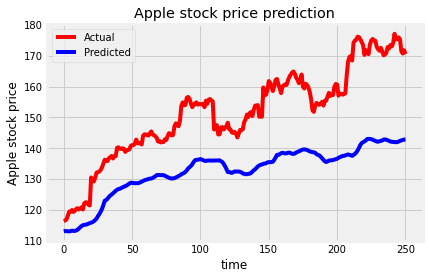

In [22]:
plot_predictions(test_2017, pred_lstm)

###RMSE of the model

In [0]:
def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("RMSE = {}.".format(rmse))

In [24]:
return_rmse(test_2017, pred_lstm)

RMSE = 20.202756067004035.


#GRU's model

In [0]:
regressorGRU = Sequential()

# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# The output layer
regressorGRU.add(Dense(units=1))

###Compile the model

In [0]:
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

###Fit the model with training set

In [27]:
regressorGRU.fit(X_train, y_train, epochs=5, batch_size=150)

Epoch 1/5
242/242 [==============================] - 1s 6ms/step - loss: 0.3329
Epoch 2/5
242/242 [==============================] - 0s 454us/step - loss: 0.1712
Epoch 3/5
242/242 [==============================] - 0s 448us/step - loss: 0.0831
Epoch 4/5
242/242 [==============================] - 0s 476us/step - loss: 0.1237
Epoch 5/5
242/242 [==============================] - 0s 441us/step - loss: 0.1700


###Predict the stock price

In [0]:
pred_gru = regressorGRU.predict(X_test)
pred_gru = sc.inverse_transform(pred_gru)

###Plot the prediction

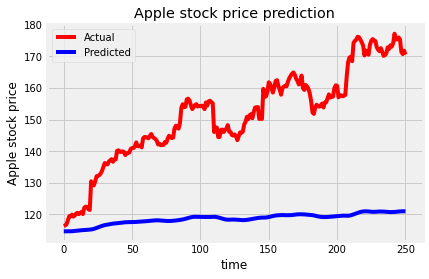

In [29]:
plot_predictions(test_2017, pred_gru)

###RMSE of the model

In [30]:
return_rmse(test_2017, pred_gru)

RMSE = 35.34441549249565.
